In [2]:
import numpy as np
import pandas as pd
from copy import copy
import sys
sys.path.append('/home/ndsviriden/MinMax94/src/utils') 
from constants import data_directory, MmxColumns
from interpolation import interpolate_mmx, create_patterns
from converters import convert_raw_to_mmx
from preprocessing import get_clean_data
from loaders import load_mm94_stations, select_mm94_features
from geographical import find_nearest_wmo_station, add_solar_angles, add_coordinates, add_road_id
from sklearn.ensemble import IsolationForest
from score import get_labels
from score import calc_precision, calc_recall, calc_f1_score
import gc
from tqdm import tqdm_notebook
from functools import reduce

## Loading data

In [3]:
%%time
test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 
                   511, 516, 1838, 1896]


train_station_id = [113, 115, 116, 118, 126, 150, 152, 200, 223, 228, 
                    239, 305, 308, 309, 401, 411, 432, 435, 454, 456, 
                    593, 628, 1831, 1899, 1911, 1921, 4007, 20323, 20717, 20743, 
                    20754, 20755, 20761, 20916, 20921]

raw = load_mm94_stations(train_station_id + test_station_id)
raw = select_mm94_features(raw, ['t_air', 't_road', 't_underroad', 'pressure', 'dampness'])

mmx_rwis = convert_raw_to_mmx(raw)
mmx_rwis_interpolated = interpolate_mmx(mmx_rwis)
data = create_patterns(mmx_rwis_interpolated)

data['data_solar_azimuth'], data['data_solar_altitude'] = add_solar_angles(data)
data['data_latitude'], data['data_longitude'] = add_coordinates(data)
data['data_road'] = add_road_id(data)
data = data.dropna(subset=('data_t_road', ))

del data[MmxColumns.ID_AIR_TEMPERATURE], data[MmxColumns.ID_UNDERGROUND_TEMPERATURE], \
    data[MmxColumns.ID_PRESSURE], data[MmxColumns.ID_HUMIDITY]

train = data[data['station_id'].isin(train_station_id)]
train = train.reset_index(drop=True)
train_clean = get_clean_data(train)


test = data[data['station_id'].isin(test_station_id)]
test = test.reset_index(drop=True)
test['label_true'] = get_labels(test, labels_type='true')

del data, raw, mmx_rwis, mmx_rwis_interpolated
gc.collect()

/home/ndsviriden/MinMax94/src/utils/geographical.py:65: RuntimeWarning: invalid value encountered in arccos
  solar_azimuth = np.arccos(cos_az) * np.sign(h_rad)


CPU times: user 1min 35s, sys: 9.46 s, total: 1min 45s
Wall time: 1min 44s


## Feature selection

In [4]:
%%time

from preprocessing import create_feature_df

point = pd.Timestamp(2015, 6, 1)

time = 0
lag_list=(1, 2, 3)
diff_list=((1, 2), (1, 3))
post_process = False
regression_mode = False
variables = ['data_t_road']

df_train = create_feature_df(train_clean[train_clean['date_time_utc'] < point], coordinates=False,
                             winter_period=False, time=time, lag_list=lag_list, road_id=False, 
                             diff_list=diff_list, post_process=post_process, variables=variables)
df_valid = create_feature_df(train_clean[train_clean['date_time_utc'] >= point], coordinates=False,
                             winter_period=False, time=time, lag_list=lag_list, road_id=False,
                             diff_list=diff_list, post_process=post_process, variables=variables)
df_test = create_feature_df(test, coordinates=False,
                            winter_period=False, time=time, lag_list=lag_list, road_id=False,
                            diff_list=diff_list, post_process=post_process, variables=variables)

features = [col for col in df_train if col.startswith('data_')]
target = [col for col in df_train if col.startswith('target_')]

X_train = np.array(df_train[features + target].values)
#y_train = np.array(df_train[target])

X_valid = np.array(df_valid[features + target])
#y_valid = np.array(df_valid[target])

X_test = np.array(df_test[features + target])
#y_test = np.array(df_test[target].values.reshape(-1, 1))

CPU times: user 2.93 s, sys: 141 µs, total: 2.93 s
Wall time: 2.93 s


In [4]:
from sklearn.covariance import EllipticEnvelope

clf = EllipticEnvelope(contamination=0.001)
clf.fit(X_train)

/home/ndsviriden/.local/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
/home/ndsviriden/.local/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-111.580588382420203 > -114.579823402527808)
  % (det, previous_det), RuntimeWarning)
/home/ndsviriden/.local/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-112.398124331394200 > -117.487163356945473)
  % (det, previous_det), RuntimeWarning)
/home/ndsviriden/.local/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-113.284617685630920 > -113.645216111726327)
  % (det, previous_det), RuntimeWarning)
/home/ndsviriden/.local/lib/python3.5/site-packages/sklearn/covariance/r

/home/ndsviriden/.local/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-113.617815696713251 > -114.514193346850220)
  % (det, previous_det), RuntimeWarning)
/home/ndsviriden/.local/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-118.351772441392200 > -119.174933593186921)
  % (det, previous_det), RuntimeWarning)
/home/ndsviriden/.local/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:165: RuntimeWarning: Warning! det > previous_det (-114.276649338449147 > -115.378522093846186)
  % (det, previous_det), RuntimeWarning)


EllipticEnvelope(assume_centered=False, contamination=0.001,
         random_state=None, store_precision=True, support_fraction=None)

In [9]:
import pickle

pickle.dump(clf, open('/mnt/HARD/MinMax94/models/pickle/elliptic_envelope.pickle', "wb"))

In [16]:
import pickle

clf = pickle.load(open('/mnt/HARD/MinMax94/models/pickle/elliptic_envelope_artificial.pickle', "rb"))

In [17]:
y_true = df_test['label_true']
df_test['label_predict'] = (1 - clf.predict(X_test)) / 2 
df_test['decision_function'] =  clf.decision_function(X_test)

In [13]:
df_test.to_csv('/mnt/HARD/MinMax94/models/results/elliptic_envelope_artificial.csv', index=False)

## Recall

In [18]:
window = pd.Timedelta('5h')
st_id = [114, 119, 302, 303, 442, 504, 511, 1838, 1896]

recall = calc_recall(df_test, st_id, window)
precision = calc_precision(df_test, st_id, window)
f1_score = calc_f1_score(precision, recall)

print("Recall: {0:.3f} \nPrecision: {1:.3f} \nF1:{2:.3f}".format(recall, precision, f1_score))

Recall: 0.769 
Precision: 0.257 
F1:0.385


## Cycle

In [19]:
predicted_anomalies_ids = set()
window = pd.Timedelta('4h')
station_list = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]

for station_id in station_list:
    st_id = [station_id]
    recall = calc_recall(df_test, st_id, window)
    precision = calc_precision(df_test, st_id, window)
    f1_score = calc_f1_score(precision, recall)
    
    print('{0} : F1 = {1:0.3f} R = {2:0.3f}, P = {3:0.3f}'.format(station_id, f1_score, recall, precision))

114 : F1 = 0.203 R = 0.611, P = 0.122
117 : F1 = 0.528 R = 0.408, P = 0.746
119 : F1 = 0.261 R = 0.970, P = 0.151
302 : F1 = 0.204 R = 0.578, P = 0.124
303 : F1 = 0.300 R = 0.746, P = 0.188
307 : F1 = 0.275 R = 0.174, P = 0.654
393 : F1 = 0.147 R = 0.101, P = 0.268
442 : F1 = 0.227 R = 1.000, P = 0.128
503 : F1 = 0.867 R = 0.851, P = 0.884
504 : F1 = 0.334 R = 0.872, P = 0.207
511 : F1 = 0.556 R = 1.000, P = 0.385
516 : F1 = 0.187 R = 0.202, P = 0.175
1838 : F1 = 0.384 R = 0.903, P = 0.244
1896 : F1 = 0.671 R = 0.621, P = 0.728


## Plot

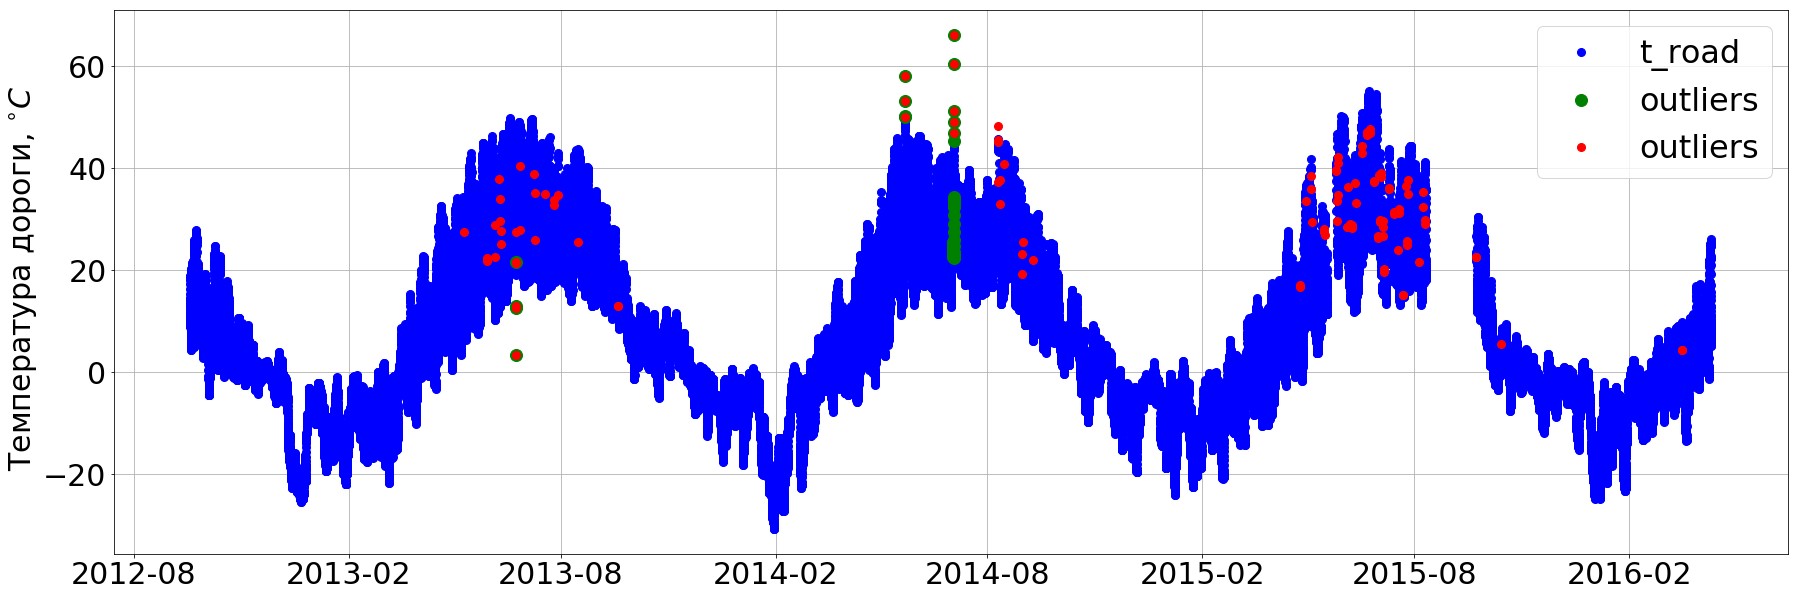

In [21]:
import matplotlib.pyplot as plt

#st_id = [114, 117, 119, 442, 504, 511, 1838, 1896]
#303, 307!!, 393!!, 503, 516
#test_station_id = [114, 117, 119, 302, 303, 307, 393, 442, 503, 504, 511, 516, 1838, 1896]
z = copy(df_test[df_test['station_id']==114].set_index('date_time_utc'))

start = pd.Timestamp(2012, 4, 1)
end = pd.Timestamp(2017, 5, 1)

to_plot = z[(z.index<=end) & (z.index>=start)]

plt.figure(figsize=(30, 10))

for elem in [True, False]:
    cond_predict = (to_plot['label_predict'] == 0) == elem
    cond_true = (to_plot['label_true'] == 0) == elem
    
    if elem:
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'b',
                      linestyle='none', marker='o', markersize=8, label='t_road')
    else:
        
        plt.plot_date(to_plot[cond_true].index, to_plot[cond_true]['target_t_road'], 'g.',
                              linestyle='none', marker='o', label='outliers', markersize=12)
        
        plt.plot_date(to_plot[cond_predict].index, to_plot[cond_predict]['target_t_road'], 'r.',
                              linestyle='none', marker='o', label='outliers', markersize=8)

plt.grid()
plt.legend(fontsize=32)
plt.ylabel(r' Температура дороги, $^{\circ}C$', fontsize=30)

plt.tick_params(labelsize=30)
plt.show()